In [8]:
import seaborn as sns
import pandas as pd
from pathlib import Path
import sys
from logging import basicConfig, INFO
import ray
import pickle
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib as mpl

from simulation import *

%load_ext autoreload
%autoreload 2

mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],  # Or Times, Computer Modern
})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Evaluation

In [15]:
import os
import pandas as pd

subdir = Path('./sims_v3')
dataframes = [pd.read_csv(csv) for csv in subdir.glob("*.csv")]
df = pd.concat(dataframes, ignore_index=True)

In [21]:
def add_util_perc(df: pd.DataFrame, col: str) -> pd.DataFrame:
    df = df.copy()
    for bias in df['gender_bias'].unique():
        mask = (df['quota'] == QuotaType.NONE.name) & (df['gender_bias'] == bias)
        none_util = df[mask].set_index('id')[col]
        df.loc[df['gender_bias'] == bias, f'{col}_perc_bias'] = df[col] / df['id'].map(none_util)
    return df

# Apply the function to add the new column
df = add_util_perc(df, 'total_util')
df = add_util_perc(df, 'g0_util')
df = add_util_perc(df, 'g1_util')

# Visualisation

In [22]:
df = df.loc[(df["quota"] != QuotaType.GTE30.name)]

In [37]:
import subprocess

filters = [
    'n_roles',
    'n_persons',
    'gender_bias',
    'total_cap',
    'alpha_caps',
    'alpha_prefs'
]
targets = ['total_util_perc', 'g0_util_perc', 'g1_util_perc']
#targets = ['total_util_perc_bias', 'g0_util_perc_bias', 'g1_util_perc_bias']
#targets = ['total_util', 'g0_util', 'g1_util']

def visualise(df):
    df_melted = df.melt(id_vars=["tvd", "quota"], value_vars=targets, var_name="target", value_name="value")
    df_melted[~(np.isfinite(df_melted["tvd"]) & np.isfinite(df_melted["value"]))] = 100  # high number for infinity.
    
    # Plot with FacetGrid
    g = sns.FacetGrid(df_melted, col="quota", hue="target", palette="Set2", col_wrap=2, height=4, aspect=1)
    g.map(sns.regplot, "tvd", "value", scatter_kws={'alpha': 0.5}, ci=None, robust=True)
    spread = 1.1
    y_min = df_melted['value'].quantile(0.05) / spread
    y_max = df_melted['value'].quantile(0.95) * spread
    g.set(ylim=(y_min, y_max))
    plt.legend(loc='lower center', bbox_to_anchor=(0, -0.25), ncol=3, frameon=False)
    plt.show()

def filter_and_visualize(**kwargs):
    filtered_df = df.copy()

    for key, value in kwargs.items():
        filtered_df = filtered_df[filtered_df[key] == value]
    
    # Show visualization
    if not filtered_df.empty:
        visualise(filtered_df)
    else:
        print("No data matches the filter criteria.")

dropdowns = {col: widgets.Dropdown(options=sorted(df[col].unique()), description=col) for col in filters}

# Link widgets to the output
ui = widgets.HBox(list(dropdowns.values()))
out = widgets.interactive_output(filter_and_visualize, dropdowns)

# Display widgets and output
display(ui, out)

Output()

## Plot

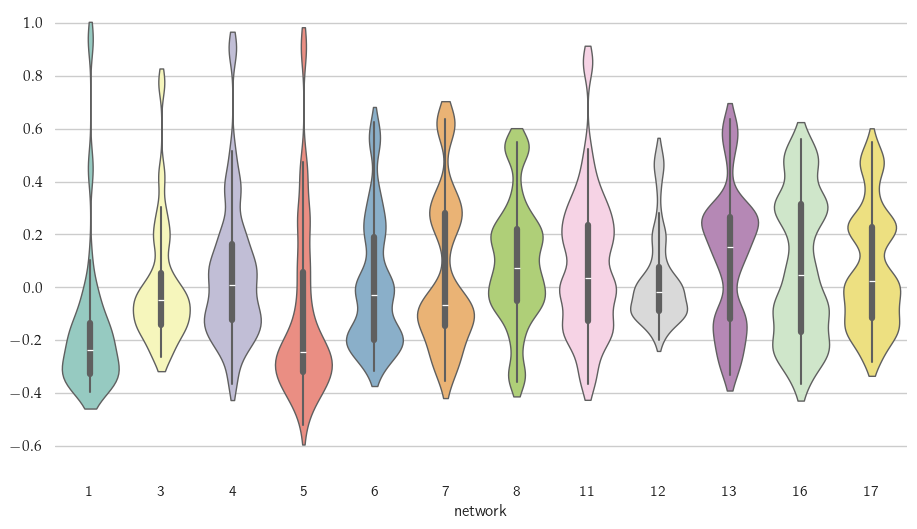

In [28]:
sns.set_theme(style="whitegrid")

# Load the example dataset of brain network correlations
df = sns.load_dataset("brain_networks", header=[0, 1, 2], index_col=0)

# Pull out a specific subset of networks
used_networks = [1, 3, 4, 5, 6, 7, 8, 11, 12, 13, 16, 17]
used_columns = (df.columns.get_level_values("network")
                          .astype(int)
                          .isin(used_networks))
df = df.loc[:, used_columns]

# Compute the correlation matrix and average over networks
corr_df = df.corr().groupby(level="network").mean()
corr_df.index = corr_df.index.astype(int)
corr_df = corr_df.sort_index().T

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 6))

# Draw a violinplot with a narrower bandwidth than the default
sns.violinplot(data=corr_df, bw_adjust=.5, cut=1, linewidth=1, palette="Set3")

# Finalize the figure
ax.set(ylim=(-.7, 1.05))
sns.despine(left=True, bottom=True)

In [92]:
filters = [
    'n_roles',
    'n_persons',
    'total_cap',
]
targets = ['total_util_perc', 'g0_util_perc', 'g1_util_perc']
#targets = ['total_util', 'g0_util', 'g1_util']

def visualise(df, target):
    df_violin = df[['id', 'quota', 'gender_bias', target]]
    df_violin = df_violin.set_index(['id', 'quota'])
    df_violin = df_violin.pivot(columns='gender_bias', values=target)
    df_violin = df_violin[['NONE', 'LOW', 'MEDIUM', 'HIGH', 'VERY_HIGH', 'EXTREME']]
    sns.violinplot(data=df_violin, bw_adjust=.5, cut=1, linewidth=1, palette="Set3")
    plt.ylim(0.6, 1.1)
    plt.show()

def filter_and_visualize(**kwargs):
    target = kwargs.pop('target')
    tvd = kwargs.pop('tvd')
    tvd_dir = kwargs.pop('tvd_dir')
    filtered_df = df.copy()

    if tvd_dir == 'UP':
        filtered_df = filtered_df[filtered_df['tvd'] >= float(tvd)]
    else:
        filtered_df = filtered_df[filtered_df['tvd'] <= float(tvd)]

    for key, value in kwargs.items():
        filtered_df = filtered_df[filtered_df[key] == value]
    
    # Show visualization
    if not filtered_df.empty:
        visualise(filtered_df, target)
    else:
        print("No data matches the filter criteria.")

dropdowns = {col: widgets.Dropdown(options=sorted(df[col].unique()), description=col) for col in filters}
dropdowns['target'] = widgets.Dropdown(options=targets, description='target')
dropdowns['quota'] = widgets.Dropdown(options=['NONE', 'GTE20', 'GTE30', 'GTE40', 'EQU50'], description='quota')
dropdowns['tvd'] = widgets.Dropdown(options=['0.0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0'], description='tvd')
dropdowns['tvd_dir'] = widgets.Dropdown(options=['UP', 'DOWN'], description='tvd_dir')

# Link widgets to the output
ui = widgets.HBox(list(dropdowns.values()))
out = widgets.interactive_output(filter_and_visualize, dropdowns)

# Display widgets and output
display(ui, out)

Output()

In [96]:
filters = [
    'n_roles',
    'n_persons',
    'total_cap',
]
targets = ['total_util_perc', 'g0_util_perc', 'g1_util_perc']
#targets = ['total_util', 'g0_util', 'g1_util']

def visualise(df, target):
    df_violin = df[['id', 'quota', 'gender_bias', target]]
    df_violin = df_violin.set_index(['id', 'gender_bias'])
    df_violin = df_violin.pivot(columns='quota', values=target)
    df_violin = df_violin[['NONE', 'GTE20', 'GTE30', 'GTE40', 'EQU50']]
    sns.violinplot(data=df_violin, bw_adjust=.5, cut=1, linewidth=1, palette="Set3")
    # plt.ylim(0.6, 1.1)
    plt.show()

def filter_and_visualize(**kwargs):
    target = kwargs.pop('target')
    tvd = kwargs.pop('tvd')
    tvd_dir = kwargs.pop('tvd_dir')
    filtered_df = df.copy()

    if tvd_dir == 'UP':
        filtered_df = filtered_df[filtered_df['tvd'] >= float(tvd)]
    else:
        filtered_df = filtered_df[filtered_df['tvd'] <= float(tvd)]

    for key, value in kwargs.items():
        filtered_df = filtered_df[filtered_df[key] == value]
    
    # Show visualization
    if not filtered_df.empty:
        visualise(filtered_df, target)
    else:
        print("No data matches the filter criteria.")

dropdowns = {col: widgets.Dropdown(options=sorted(df[col].unique()), description=col) for col in filters}
dropdowns['target'] = widgets.Dropdown(options=targets, description='target')
dropdowns['gender_bias'] = widgets.Dropdown(options=['NONE', 'LOW', 'MEDIUM', 'HIGH', 'VERY_HIGH', 'EXTREME'], description='gender bias')
dropdowns['tvd'] = widgets.Dropdown(options=['0.0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0'], description='tvd')
dropdowns['tvd_dir'] = widgets.Dropdown(options=['UP', 'DOWN'], description='tvd_dir')

# Link widgets to the output
ui = widgets.HBox(list(dropdowns.values()))
out = widgets.interactive_output(filter_and_visualize, dropdowns)

# Display widgets and output
display(ui, out)

Output()

In [66]:
df

,id,lambda,n_roles,n_persons,gender_bias,alpha_prefs,alpha_caps,total_g0,total_g1,total_cap,...,g0_caps_perc,g1_role,g1_caps_perc,g1_g0_perc,n_alloc,alloc_persons_perc,alloc_caps_perc,total_util_perc,g0_util_perc,g1_util_perc
0,23555752,1,20,50,NONE,1,5,25,25,100,...,[0.03333333 0. 0. 1. 0...,[ 0 12 0 0 2 0 0 0 1 0 0 7 2 0 1 ...,[0. 1. 0. 0. 1. 0. 0. 0. 0.5 0. 0. 0...,[0. 1. nan 0. 1. 0. 0. n...,50,1.0,0.5,1.000000,1.000000,1.000000
1,23555752,1,20,50,LOW,1,5,25,25,100,...,[0.03333333 0. 0. 1. 0...,[ 0 12 0 0 2 0 0 0 1 0 0 7 2 0 1 ...,[0. 1. 0. 0. 1. 0. 0. 0. 0.5 0. 0. 0...,[0. 1. nan 0. 1. 0. 0. n...,50,1.0,0.5,1.000000,1.000000,1.000000
2,23555752,1,20,50,MEDIUM,1,5,25,25,100,...,[0.03333333 0. 0. 1. 0...,[ 0 12 0 0 2 0 0 0 1 0 0 7 2 0 1 ...,[0. 1. 0. 0. 1. 0. 0. 0. 0.5 0. 0. 0...,[0. 1. nan 0. 1. 0. 0. n...,50,1.0,0.5,1.000000,1.000000,1.000000
3,23555752,1,20,50,HIGH,1,5,25,25,100,...,[0.03333333 0. 0. 1. 0...,[ 0 12 0 0 2 0 0 0 1 0 0 7 2 0 1 ...,[0. 1. 0. 0. 1. 0. 0. 0. 0.5 0. 0. 0...,[0. 1. nan 0. 1. 0. 0. n...,50,1.0,0.5,1.000000,1.000000,1.000000
4,23555752,1,20,50,VERY_HIGH,1,5,25,25,100,...,[0.03333333 0. 0. 1. 0...,[ 0 12 0 0 2 0 0 0 1 0 0 7 2 0 1 ...,[0. 1. 0. 0. 1. 0. 0. 0. 0.5 0. 0. 0...,[0. 1. nan 0. 1. 0. 0. n...,50,1.0,0.5,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227995,13271528,1,10,100,LOW,1,5,50,50,20,...,[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5],[1 1 1 1 1 1 1 1 1 1],[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5],[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5],20,0.2,1.0,0.914732,0.892626,0.939063
227996,13271528,1,10,100,MEDIUM,1,5,50,50,20,...,[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5],[1 1 1 1 1 1 1 1 1 1],[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5],[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5],20,0.2,1.0,0.914732,0.892626,0.939063
227997,13271528,1,10,100,HIGH,1,5,50,50,20,...,[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5],[1 1 1 1 1 1 1 1 1 1],[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5],[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5],20,0.2,1.0,0.914732,0.892626,0.939063
227998,13271528,1,10,100,VERY_HIGH,1,5,50,50,20,...,[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5],[1 1 1 1 1 1 1 1 1 1],[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5],[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5],20,0.2,1.0,0.914732,0.892626,0.939063


In [60]:
df_violin = df[['tvd', 'quota', 'gender_bias', 'total_util_perc']]
df_violin[:]

,tvd,quota,gender_bias,total_util_perc
0,0.769064,NONE,NONE,1.000000
1,0.769064,NONE,LOW,1.000000
2,0.769064,NONE,MEDIUM,1.000000
3,0.769064,NONE,HIGH,1.000000
4,0.769064,NONE,VERY_HIGH,1.000000
...,...,...,...,...
227995,0.244435,EQU50,LOW,0.914732
227996,0.244435,EQU50,MEDIUM,0.914732
227997,0.244435,EQU50,HIGH,0.914732
227998,0.244435,EQU50,VERY_HIGH,0.914732


In [50]:
df.columns

Index(['id', 'lambda', 'n_roles', 'n_persons', 'gender_bias', 'alpha_prefs',
       'alpha_caps', 'total_g0', 'total_g1', 'total_cap', 'caps', 'tvd',
       'quota', 'success', 'fun', 'total_util', 'total_util_biased', 'g0_util',
       'g1_util', 'g0_role', 'g0_caps_perc', 'g1_role', 'g1_caps_perc',
       'g1_g0_perc', 'n_alloc', 'alloc_persons_perc', 'alloc_caps_perc',
       'total_util_perc', 'g0_util_perc', 'g1_util_perc'],
      dtype='object')

In [45]:
df.loc[(df["quota"] == QuotaType.NONE.name) & (df["gender_bias"] == 'VERY_HIGH')]

,id,lambda,n_roles,n_persons,gender_bias,alpha_prefs,alpha_caps,total_g0,total_g1,total_cap,...,g0_caps_perc,g1_role,g1_caps_perc,g1_g0_perc,n_alloc,alloc_persons_perc,alloc_caps_perc,total_util_perc,g0_util_perc,g1_util_perc
4,27314800,1,10,100,VERY_HIGH,1,5,50,50,50,...,[1. 0.33333333 1. 0.53846154 1...,[0 2 0 6 0 0 3 0 0 0],[0. 0.66666667 0. 0.46153846 0...,[0. 0.66666667 0. 0.46153846 0...,50,0.50,1.00,1.0,1.0,1.0
34,78725467,1,10,100,VERY_HIGH,1,5,50,50,50,...,[1. 0.88888889 1. 1. 1...,[0 1 0 0 0 1 0 0 0 0],[0. 0.11111111 0. 0. 0...,[0. 0.11111111 0. 0. 0...,50,0.50,1.00,1.0,1.0,1.0
64,78839409,1,10,100,VERY_HIGH,1,5,50,50,50,...,[1. 1. 1. 1. 1...,[0 0 0 0 0 0 0 2 0 0],[0. 0. 0. 0. 0...,[0. 0. 0. 0. 0...,50,0.50,1.00,1.0,1.0,1.0
94,10420106,1,10,100,VERY_HIGH,1,5,50,50,50,...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.],[0 0 0 0 0 0 0 0 0 0],[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.],[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.],50,0.50,1.00,1.0,1.0,NaN
124,53027795,1,10,100,VERY_HIGH,1,5,50,50,50,...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.],[0 0 0 0 0 0 0 0 0 0],[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.],[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.],50,0.50,1.00,1.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323854,17363255,1,20,100,VERY_HIGH,1,5,50,50,100,...,[0.41176471 0.2 1. 1. 0...,[20 4 0 0 6 2 0 2 1 1 0 3 0 1 8 ...,[0.58823529 0.8 0. 0. 0...,[0.58823529 0.8 0. 0. 0...,100,1.00,1.00,1.0,1.0,1.0
323884,12196376,1,20,100,VERY_HIGH,1,5,50,50,100,...,[0.25 0.16666667 0. 0.55555556 0...,[ 3 2 4 4 2 0 4 4 1 2 2 4 2 10 1 ...,[0.75 0.33333333 1. 0.44444444 0...,[0.75 0.66666667 1. 0.44444444 0...,97,0.97,0.97,1.0,1.0,1.0
323914,71091062,1,20,100,VERY_HIGH,1,5,50,50,100,...,[1. 1. 0.30769231 1. 0...,[ 0 0 9 0 2 2 1 11 1 1 2 2 1 2 1 ...,[0. 0. 0.69230769 0. 0...,[0. 0. 0.69230769 0. 0...,89,0.89,0.89,1.0,1.0,1.0
323944,78264531,1,20,100,VERY_HIGH,1,5,50,50,100,...,[0.5 1. 0.33333333 1. 0...,[ 5 0 4 0 8 10 7 0 1 0 0 0 1 3 3 ...,[0.5 0. 0.66666667 0. 0...,[0.5 0. 0.66666667 0. 0...,100,1.00,1.00,1.0,1.0,1.0


In [30]:
df

network           1                     3                     4             \
node              1                     1                     1              
hemi             lh         rh         lh         rh         lh         rh   
0         56.055744  92.031036  26.203819 -49.715569  47.461037  26.746613   
1         55.547253  43.690075 -28.274963 -39.050129  -1.210660 -19.012897   
2         60.997768  63.438793 -18.842947  -1.214659 -65.575806 -85.777428   
3         18.514868  12.657158  -7.420454  17.119448 -41.800869 -58.610184   
4         -2.527392 -63.104668 -45.216927   3.483550 -62.613335 -49.076508   
..              ...        ...        ...        ...        ...        ...   
915       -7.429513  -4.813219 -19.680431 -29.109356  -3.376562  -8.764893   
916      -33.554138 -38.605621   5.562785  20.182186  17.911247  24.653582   
917      -78.539566 -74.197189 -14.277059 -30.606461  60.628521  62.027023   
918     -103.235825 -98.744286  12.109148   1.621340  33.765560  55.356071   
919      -36.288868 -10.762070  14.252188 -27.559860  17.279512 -19.060152   

network          5                     6             ...          16  \
node             1                     1             ...           3   
hemi            lh         rh         lh         rh  ...          rh   
0       -35.898861  -1.889181   5.898688 -43.692322  ...    0.607904   
1        19.568010  15.902983 -23.231823 -10.745867  ...   57.495071   
2        19.247454  37.209419   2.392153  16.509109  ...   28.317369   
3        32.896915  11.199619 -14.665752   2.073715  ...   71.439629   
4        18.396759   3.219077 -41.856911 -24.690414  ...   95.597565   
..             ...        ...        ...        ...  ...         ...   
915       0.017912 -25.305094 -75.461159 -70.289261  ...   58.285793   
916     -32.935612 -21.783203 -16.198238 -34.893780  ...   59.864819   
917     -32.800556 -37.021500   2.098941 -18.581594  ...   68.767868   
918     -14.330512 -17.224781  -3.007454 -42.672840  ...  103.155251   
919      26.558777  21.377319   9.652065  12.693388  ...  102.086304   

network                                 17                                   \
node              4                      1                     2              
hemi             lh          rh         lh         rh         lh         rh   
0        -70.270546   77.365776 -21.734550   1.028253   7.791784  68.903725   
1        -76.393219  127.261360 -13.035799  46.381824 -15.752450  31.000332   
2          9.063977   45.493263  26.033442  34.212200   1.326110 -22.580757   
3         65.842979  -10.697547  55.297466   4.255006  -2.420144  12.098393   
4         50.960453  -23.197300  43.067562  52.219875  28.232882 -11.719750   
..              ...         ...        ...        ...        ...        ...   
915       68.557411   22.833048  76.179489  51.934669  -6.614513  -6.690762   
916       23.004578    7.657463  50.962399  13.696922  63.503616  57.401176   
917       49.664017   64.551498  43.800747   8.144480  47.281460  70.499649   
918      106.454849    9.046827  46.674419  40.954796   0.877180  37.577152   
919       80.051140   -2.642610 -12.229620  -6.596726  17.665163  16.153173   

network                                    
node             3                      4  
hemi            lh          rh         lh  
0       -10.520872  120.490463 -39.686432  
1       -39.607521   24.764011 -36.771008  
2        12.985169  -75.027451   6.434262  
3       -15.819172  -37.361431  -4.650954  
4         5.453649    5.169828  87.809135  
..             ...         ...        ...  
915      22.893030   48.274380  76.228455  
916      24.974548   51.972153  64.538788  
917      66.994400   81.539246  64.969772  
918      20.517746    3.124434  56.718388  
919       8.300399   33.687531  17.960655  

[920 rows x 52 columns]

In [46]:
df.head()

,id,lambda,n_roles,n_persons,gender_bias,alpha_prefs,alpha_caps,total_g0,total_g1,total_cap,...,g0_caps_perc,g1_role,g1_caps_perc,g1_g0_perc,n_alloc,alloc_persons_perc,alloc_caps_perc,total_util_perc,g0_util_perc,g1_util_perc
0,27314800,1,10,100,NONE,1,5,50,50,50,...,[1. 0. 1. 0.15384615 1...,[ 0 3 0 11 0 3 5 4 0 0],[0. 1. 0. 0.84615385 0...,[0. 1. 0. 0.84615385 0...,50,0.5,1.0,1.0,1.0,1.0
1,27314800,1,10,100,LOW,1,5,50,50,50,...,[1. 0. 1. 0.23076923 1...,[ 0 3 0 10 0 2 5 4 0 0],[0. 1. 0. 0.76923077 0...,[0. 1. 0. 0.76923077 0...,50,0.5,1.0,1.0,1.0,1.0
2,27314800,1,10,100,MEDIUM,1,5,50,50,50,...,[1. 0. 1. 0.30769231 1...,[0 3 0 9 0 1 5 2 0 0],[0. 1. 0. 0.69230769 0...,[0. 1. 0. 0.69230769 0...,50,0.5,1.0,1.0,1.0,1.0
3,27314800,1,10,100,HIGH,1,5,50,50,50,...,[1. 0.33333333 1. 0.38461538 1...,[0 2 0 8 0 0 5 1 0 0],[0. 0.66666667 0. 0.61538462 0...,[0. 0.66666667 0. 0.61538462 0...,50,0.5,1.0,1.0,1.0,1.0
4,27314800,1,10,100,VERY_HIGH,1,5,50,50,50,...,[1. 0.33333333 1. 0.53846154 1...,[0 2 0 6 0 0 3 0 0 0],[0. 0.66666667 0. 0.46153846 0...,[0. 0.66666667 0. 0.46153846 0...,50,0.5,1.0,1.0,1.0,1.0


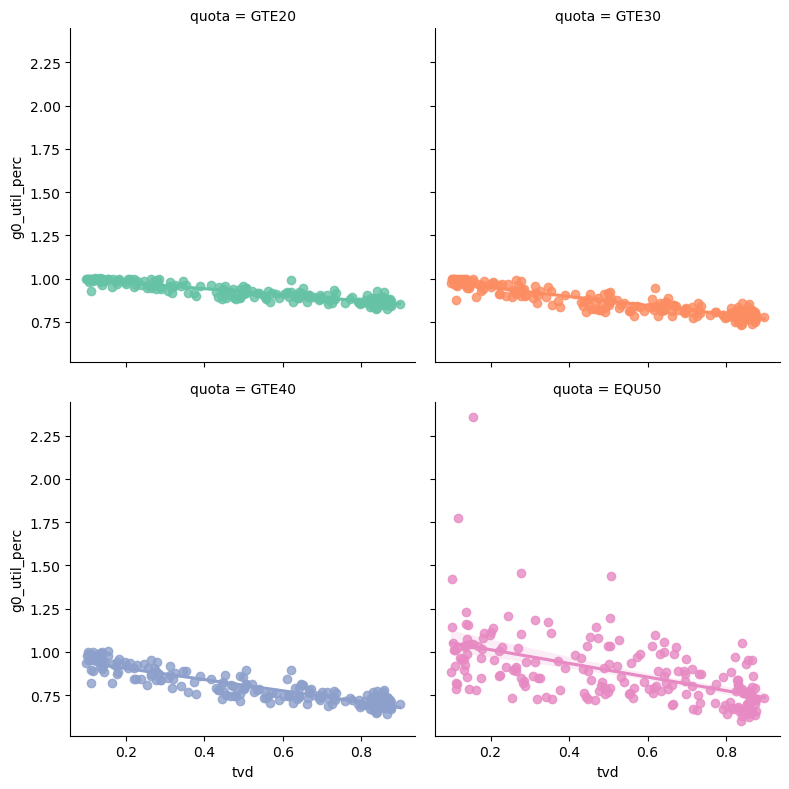

In [152]:
sns.lmplot(data=df.loc[df["quota"] != QuotaType.NONE.name], x="tvd", y="g0_util_perc", hue="quota", palette="Set2", height=4, col="quota", col_wrap=2, aspect=1)

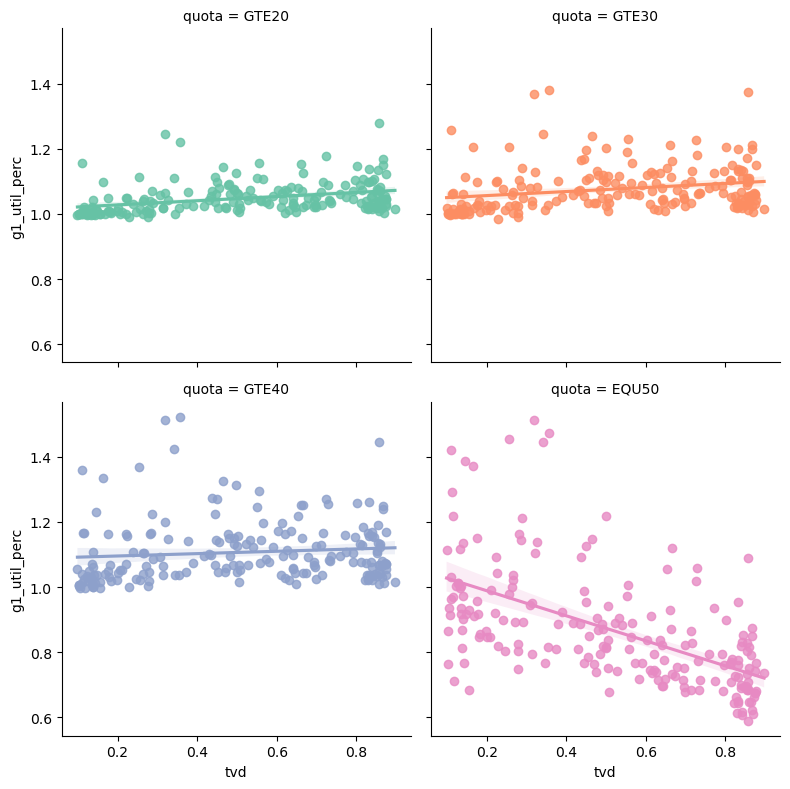

In [153]:
sns.lmplot(data=df.loc[df["quota"] != QuotaType.NONE.name], x="tvd", y="g1_util_perc", hue="quota", palette="Set2", height=4, col="quota", col_wrap=2, aspect=1)

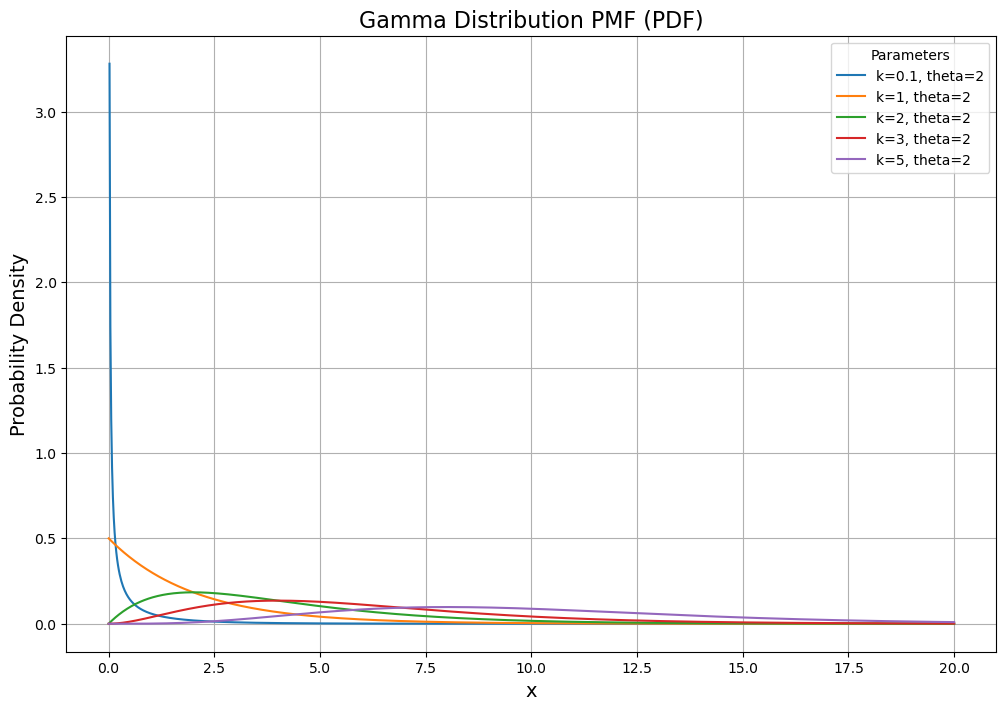

In [16]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gamma

# Define the parameters for the Gamma distribution
shape_params = [0.1, 1, 2, 3, 5]  # Shape parameters (k)
scale_params = [2]  # Scale parameters (theta)

# Create a grid for the x values
x = np.linspace(0, 20, 1000)

# Initialize the plot
plt.figure(figsize=(12, 8))

# Loop through each combination of shape and scale parameters
for k in shape_params:
    for theta in scale_params:
        # Compute the PMF (or PDF, as PMF is typically for discrete)
        pmf_values = gamma.pdf(x, a=k, scale=theta)

        # Plot the values
        sns.lineplot(x=x, y=pmf_values, label=f"k={k}, theta={theta}")

# Customize the plot
plt.title("Gamma Distribution PMF (PDF)", fontsize=16)
plt.xlabel("x", fontsize=14)
plt.ylabel("Probability Density", fontsize=14)
plt.legend(title="Parameters")
plt.grid(True)

# Show the plot
plt.show()

<Axes: >

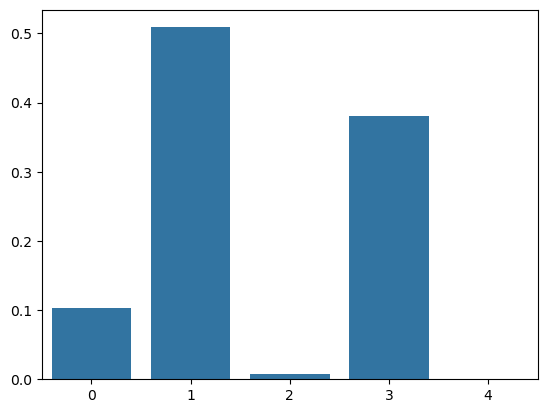

In [28]:
k = np.random.choice(len(simulations))
idx = np.random.choice(simulations[k].data.prefs.shape[0])
sns.barplot(simulations[k].data.prefs[idx])

In [107]:
stick_breaking(10, 10)

array([0.11407941, 0.32570107, 0.02767615, 0.00592941, 0.20433529,
       0.00076306, 0.0833997 , 0.12062375, 0.11582296, 0.0016692 ])